In [29]:
# Install required packages

import os
import sys
print(sys.executable)

sys.path.append(os.path.abspath(".."))  # Zurück in das Hauptverzeichnis

# Imports
import ast
import random
from collections import deque
import astunparse
import networkx as nx
from digraph_transformer import dataflow_parser
import matplotlib.pyplot as plt
from python_graphs.program_graph_dataclasses import EdgeType
from python_graphs import program_graph_dataclasses as pb  # For pb.Edge





/nfs/homedirs/hifl/miniconda3/bin/python


In [30]:
# Code-Snippets of three f1 scores
code1 = """
def test_function():
    i = 0
    while i < 5:
        print(f"Iteration {i}")
        i += 1
"""

code2 = """
def f1_score(pred, label):
    correct = pred == label
    tp = (correct & label).sum()
    fn = (~correct & ~pred).sum()
    fp = (~correct & pred).sum()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return (2 * (precision * recall) / (precision + recall))
"""

code3 = """
def f1_score(pred, label):
    correct = pred == label
    tp = (correct & label).sum()
    fn = (~correct & ~pred).sum()
    recall = tp / (tp + fn)
    fp = (~correct & pred).sum()
    precision = tp / (tp + fp)
    return (2 * (precision * recall) / (precision + recall))
"""

In [31]:
# Code Snippet from the Appendix
simple_code = """
def transform_add(a, b: float = 3.14):
    a = a**2
    c = math.sqrt(b)
    return c + a
"""

In [32]:
# Parse the ASTs
tree1 = ast.parse(code1)
tree2 = ast.parse(code2)
tree3 = ast.parse(code3)
simple_tree = ast.parse(simple_code)

# Extract the Function Bodies
function_body1 = tree1.body[0].body
function_body2 = tree2.body[0].body
function_body3 = tree3.body[0].body
simple_body = simple_tree.body[0].body

In [33]:
# Function for detailed output of the AST nodes
def print_ast_details(body, label):
    print(f"{label}:\n")
    for stmt in body:
        print(ast.dump(stmt, annotate_fields=True, include_attributes=True))
    print("\n" + "=" * 50 + "\n")

In [34]:
def non_deterministic_topological_sort(graph):
    # Check if DAG
    pos = nx.spring_layout(graph, seed=225)  # Seed for reproducible layout
    nx.draw(graph, pos)
    plt.show()

    if not nx.is_directed_acyclic_graph(graph):
        raise ValueError("Graph contains a cycle!")

    graph_copy = graph.copy()
    topo_order = []

    # Find nodes with no incoming edges (sources)
    sources = deque([node for node in graph_copy.nodes if graph_copy.in_degree(node) == 0])

    while sources:
        # Select a source node randomly and add it to topo_order
        random_index = random.randint(0, len(sources) - 1)
        node = sources[random_index]
        sources.remove(node)
        topo_order.append(node)

        # Remove the node from the graph and update sources
        successors = list(graph_copy.successors(node))
        random.shuffle(successors)

        for successor in successors:
            graph_copy.remove_edge(node, successor)
            if graph_copy.in_degree(successor) == 0:
                sources.append(successor)

        # Remove the processed node from the graph
        graph_copy.remove_node(node)

    return topo_order


In [35]:
class ASTReconstructor(ast.NodeTransformer):
    def __init__(self, graph, topo_sort):
        self.graph = graph
        self.topo_sort = topo_sort  
        self.ast_map = {node_id: graph.nodes[node_id].ast_node for node_id in topo_sort}
        self.reconstructed_body = []

    def visit_FunctionDef(self, node):
        self.generic_visit(node)
        node.body = self.reorder_body(node.body)
        return node
    
    def visit_If(self, node):
        self.generic_visit(node)
        node.body = self.reorder_body(node.body)
        node.orelse = self.reorder_body(node.orelse)
        return node
    
    def visit_For(self, node):
        self.generic_visit(node)
        node.body = self.reorder_body(node.body)
        node.orelse = self.reorder_body(node.orelse)
        return node

    def visit_While(self, node):
        self.generic_visit(node)
        node.body = self.reorder_body(node.body)
        node.orelse = self.reorder_body(node.orelse)
        return node
    
    def visit_Try(self, node):
        self.generic_visit(node)
        node.body = self.reorder_body(node.body)
        for handler in node.handlers:
            handler.body = self.reorder_body(handler.body)
        node.orelse = self.reorder_body(node.orelse)
        node.finalbody = self.reorder_body(node.finalbody)
        return node
    
    def visit_BinOp(self, node):
            self.generic_visit(node)
            if node.op.__class__.__name__ in ("Add", "Mult", "BitOr", "BitXor"):
                if random.choice([True, False]):
                    node.left, node.right = node.right, node.left
            return node

    def reorder_body(self, body):
        # Filter the nodes of the current body and sort them by topological order
        body_ids = [id(stmt) for stmt in body if isinstance(stmt, ast.stmt)]
        reordered_body = [self.ast_map[node_id] for node_id in self.topo_sort if id(self.ast_map[node_id]) in body_ids]
        return reordered_body

def graph_to_ast(graph, topo_sort):
    # Use the first node of the AST according to the topo_sort as the starting point
    first_node_id = topo_sort[0]
    root_node = graph.nodes[first_node_id].ast_node

    # Use the ASTReconstructor
    reconstructor = ASTReconstructor(graph, topo_sort)
    reconstructor.visit(root_node)

    return root_node

In [36]:
class ASTOrder(ast.NodeVisitor):
    def __init__(self, graph):
        self.index = 0
        self.node_to_order = {}
        self.graph = graph

    def visit(self, node):
        self.node_to_order[id(node)] = self.index
        self.index += 1
        self.generic_visit(node)

    def reorder_graph(self):
        edges_to_remove = []
        for edge in self.graph.edges:
            if (self.node_to_order[id(self.graph.nodes[edge.id1].ast_node)] > self.node_to_order[id(self.graph.nodes[edge.id2].ast_node)]) or (edge.id1 == edge.id2):
                edges_to_remove.append(edge)
        
        for edge in edges_to_remove:
            self.graph.edges.remove(edge)


Dependencies, die von außerhalb eines If-Blocks in einen If-Block Zeigen, müssen auch auf höheren Ebenen sichtbar gemacht werden!

In [37]:

def add_control_block_dependencies(graph):
    for node_id in graph.nodes:
        ast_node = graph.get_node(node_id).ast_node
        if ast_node.__class__.__name__ in ["If", "For", "Try", "While"]:
            # Collect all nodes inside the body, orelse, and handlers
            body_node_ids = [graph.get_node_by_ast_node(stmt).id for stmt in ast_node.body]
            orelse_node_ids = [graph.get_node_by_ast_node(stmt).id for stmt in ast_node.orelse]
            handler_node_ids = []
            if ast_node.__class__.__name__ == "Try":
                for handler in ast_node.handlers:
                    handler_node_ids.extend([graph.get_node_by_ast_node(stmt).id for stmt in handler.body])

            # Collect the node for the condition (test) or loop variable and iterable (target and iter)
            if ast_node.__class__.__name__ == "If":
                control_node_ids = [graph.get_node_by_ast_node(ast_node.test).id]
            elif ast_node.__class__.__name__ == "For":
                control_node_ids = [graph.get_node_by_ast_node(ast_node.target).id, graph.get_node_by_ast_node(ast_node.iter).id]
            elif ast_node.__class__.__name__ == "While":
                control_node_ids = [graph.get_node_by_ast_node(ast_node.test).id]
            else:  # Try
                control_node_ids = []

            # Combine body, orelse, handlers, and control nodes as the block
            block_nodes = set(body_node_ids + orelse_node_ids + handler_node_ids + control_node_ids)

            print(f"{ast_node.__class__.__name__} block nodes: {block_nodes.__str__()}")
            node_names = [graph.get_node(node_id).ast_node.__class__.__name__ for node_id in block_nodes]
            print(f"Node names in {ast_node.__class__.__name__} block: {node_names}")

            # Check dependencies for each inner node
            for inner_node_id in block_nodes:
                for edge in graph.edges:
                    if edge.id2 == inner_node_id:  # Check if there is an incoming dependency
                        if edge.id1 not in block_nodes and edge.id1 != node_id:  # From outside the block and not the block node itself
                            # Create a pb.Edge object
                            new_edge = pb.Edge(id1=edge.id1, id2=node_id, type=edge.type)
                            if not any(e.id1 == new_edge.id1 and e.id2 == new_edge.id2 and e.type == new_edge.type for e in graph.edges):
                                graph.add_edge(new_edge)
                                print(f"Added edge: {new_edge}")
                                node1_name = graph.get_node(new_edge.id1).ast_node.__class__.__name__
                                node2_name = graph.get_node(new_edge.id2).ast_node.__class__.__name__
                                print(f"Edge connects node {new_edge.id1} ({node1_name}) to node {new_edge.id2} ({node2_name})")

In [38]:
print_ast_details(function_body1, "Code")

Code:

Assign(targets=[Name(id='i', ctx=Store(), lineno=3, col_offset=4, end_lineno=3, end_col_offset=5)], value=Constant(value=0, lineno=3, col_offset=8, end_lineno=3, end_col_offset=9), lineno=3, col_offset=4, end_lineno=3, end_col_offset=9)
While(test=Compare(left=Name(id='i', ctx=Load(), lineno=4, col_offset=10, end_lineno=4, end_col_offset=11), ops=[Lt()], comparators=[Constant(value=5, lineno=4, col_offset=14, end_lineno=4, end_col_offset=15)], lineno=4, col_offset=10, end_lineno=4, end_col_offset=15), body=[Expr(value=Call(func=Name(id='print', ctx=Load(), lineno=5, col_offset=8, end_lineno=5, end_col_offset=13), args=[JoinedStr(values=[Constant(value='Iteration ', lineno=5, col_offset=16, end_lineno=5, end_col_offset=26), FormattedValue(value=Name(id='i', ctx=Load(), lineno=5, col_offset=27, end_lineno=5, end_col_offset=28), conversion=-1, lineno=5, col_offset=26, end_lineno=5, end_col_offset=29)], lineno=5, col_offset=14, end_lineno=5, end_col_offset=30)], keywords=[], lineno=

In [39]:
graph, tree1 = dataflow_parser.get_program_graph(code1)

ast_map = {id(graph.nodes[node_id].ast_node): node_id for node_id in graph.nodes}

# Filter edge type 9 as this represents the sequential connections of the original code
graph.edges = [e for e in graph.edges if e.type.value != 9]

In [40]:
add_control_block_dependencies(graph)

While block nodes: {12988552057551045051, 13412240566020392566, 12177417536860127696}
Node names in While block: ['Compare', 'AugAssign', 'Expr']
Added edge: Edge(id1=13715789896285516046, id2=12640122660490431828, type=<EdgeType.CFG_NEXT: 1>, field_name=None, has_back_edge=False)
Edge connects node 13715789896285516046 (Assign) to node 12640122660490431828 (While)


In [41]:
ast_order = ASTOrder(graph)
ast_order.visit(tree1)

# Reorder the graph to drop cycles
ast_order.reorder_graph()

In [42]:
print("Nodes: \n",graph.nodes,"\n")
print("Edges: \n", graph.edges, "\n")
print(edge for edge in graph.edges if egde.type.value == 9)

Nodes: 
 {13281012687677963469: 13281012687677963469 FunctionDef, 13715789896285516046: 13715789896285516046 Assign, 12988552057551045051: 12988552057551045051 Compare, 12177417536860127696: 12177417536860127696 Expr, 13412240566020392566: 13412240566020392566 AugAssign, 9542903355809596586: 9542903355809596586 Module, 13660306085479509328: 13660306085479509328 arguments, 12640122660490431828: 12640122660490431828 While, 10871060174999524924: 10871060174999524924 Name, 12761134314086605196: 12761134314086605196 Constant, 11731024900954660234: 11731024900954660234 Store, 11430036691556299820: 11430036691556299820 Name, 10050840785559951405: 10050840785559951405 Lt, 13077479959355837909: 13077479959355837909 Constant, 10502151304515741689: 10502151304515741689 Call, 12206370103446700584: 12206370103446700584 Name, 10425783264622447044: 10425783264622447044 Add, 12607357302502871205: 12607357302502871205 Constant, 9407068485239987029: 9407068485239987029 Load, 12913247121199011121: 129132

In [43]:
# Create a new directed graph
nx_graph = nx.DiGraph()

# Add nodes
nx_graph.add_nodes_from(graph.nodes.keys())

# Add edges with only id1 and id2
edges = [(edge.id1, edge.id2) for edge in graph.edges]
nx_graph.add_edges_from(edges)


In [44]:
tree1.body[0].body[1]

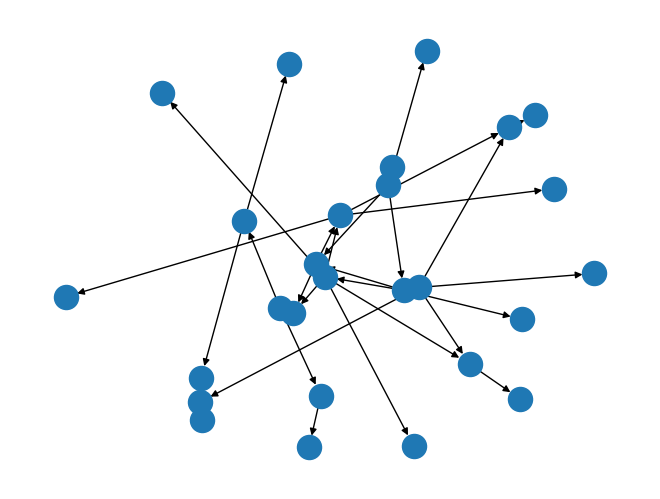

In [45]:
if nx.is_directed_acyclic_graph(nx_graph):
    topo_sort = non_deterministic_topological_sort(nx_graph)
else:
    print("The graph contains a cycle and cannot be topologically sorted.")
    try:
        cycle = nx.find_cycle(nx_graph, orientation='original')
        print("Cycle found in the graph:", cycle)
        if cycle:
            pos = nx.spring_layout(nx_graph, seed=225)
            plt.figure(figsize=(12, 8))
            nx.draw(nx_graph, pos, with_labels=True, node_color='lightblue', edge_color='gray')
            cycle_edges = [(u, v) for u, v, _ in cycle]
            nx.draw_networkx_edges(nx_graph, pos, edgelist=cycle_edges, edge_color='r', width=2)
            node1_name = graph.get_node(cycle[0][0]).ast_node.__class__.__name__
            node2_name = graph.get_node(cycle[0][1]).ast_node.__class__.__name__ if len(cycle) > 1 else "N/A"
            # Print detailed information about the nodes in the cycle
            for u, v in cycle_edges:
                node_u = graph.get_node(u)
                node_v = graph.get_node(v)
                print(f"Edge from {node_u.ast_node.__class__.__name__} to {node_v.ast_node.__class__.__name__}")
                print(f"Node {u} details: {ast.dump(node_u.ast_node, annotate_fields=True, include_attributes=True)}")
                print(f"Node {v} details: {ast.dump(node_v.ast_node, annotate_fields=True, include_attributes=True)}")

            # Handle self-cycle
            if len(cycle) == 1:
                node_u = graph.get_node(cycle[0][0])
                print(f"Self-cycle detected at node {node_u.ast_node.__class__.__name__}")
                print(f"Node details: {ast.dump(node_u.ast_node, annotate_fields=True, include_attributes=True)}")

            plt.show()
        else:
            print("No cycle found in the graph.")
    except nx.NetworkXNoCycle:
        print("No cycle found in the graph.")
        

In [46]:
# Get the node IDs for the Assign and If nodes
assign_node_id = ast_map.get(id(tree1.body[0].body[0]))
print(tree1.body[0].body[0])
if_node_id = ast_map.get(id(tree1.body[0].body[1]))
print(tree1.body[0].body[1])

# Check if the node IDs were found
if assign_node_id is None or if_node_id is None:
	print("One of the node IDs was not found in the ast_map.")
else:
	# Check if there is an edge from the Assign node to the If node
	edge_exists = any(edge.id1 == assign_node_id and edge.id2 == if_node_id for edge in graph.edges)

	print(f"Edge from 'correct = (pred == label)' to 'if (correct < 3): print(correct) else: print('ABC')' exists: {edge_exists}")
	# Check for all edges that go into the node that represents the If statement
	incoming_edges = [edge for edge in graph.edges if edge.id2 == if_node_id]

	print(f"Incoming edges to the 'if (correct < 3): print(correct) else: print('ABC')' node: {incoming_edges}")
	# Get the names of the nodes that have an edge pointing to the If node
	incoming_node_names = [graph.nodes[edge.id1].ast_node.__class__.__name__ for edge in incoming_edges]

	print(f"Nodes with edges pointing to the 'if (correct < 3): print(correct) else: print('ABC')' node: {incoming_node_names}")

Edge from 'correct = (pred == label)' to 'if (correct < 3): print(correct) else: print('ABC')' exists: True
Incoming edges to the 'if (correct < 3): print(correct) else: print('ABC')' node: [Edge(id1=13281012687677963469, id2=12640122660490431828, type=<EdgeType.FIELD: 7>, field_name='body:1', has_back_edge=False), Edge(id1=13715789896285516046, id2=12640122660490431828, type=<EdgeType.CFG_NEXT: 1>, field_name=None, has_back_edge=False)]
Nodes with edges pointing to the 'if (correct < 3): print(correct) else: print('ABC')' node: ['FunctionDef', 'Assign']


In [47]:
print(astunparse.unparse(tree1))



def test_function():
    i = 0
    while (i < 5):
        print(f'Iteration {i}')
        i += 1



In [48]:
reconstructed_ast = graph_to_ast(graph, topo_sort)
generated_code = astunparse.unparse(reconstructed_ast)
print(generated_code)



def test_function():
    i = 0
    while (i < 5):
        i += 1
        print(f'Iteration {i}')

